<a href="https://colab.research.google.com/github/Lavyadev/EXXA/blob/main/Image_Based_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [76]:
import os
from astropy.io import fits
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_msssim import ms_ssim



class FITSDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.fits')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        with fits.open(file_path) as hdul:
            data = hdul[0].data.astype(np.float32)

            data = data * 1e11

            original_min = np.min(data)
            original_max = np.max(data)

            data = (data - original_min) / (original_max - original_min + 1e-8)
            data = np.nan_to_num(data)


        data = np.squeeze(data)

        if data.ndim == 3:
            data = data[0]
        elif data.ndim == 2:
            pass
        else:
            raise ValueError(f"Unexpected data shape after squeeze: {data.shape}")

        data = np.expand_dims(data, axis=0)

        tensor = torch.tensor(data)
        tensor = F.interpolate(tensor.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, tensor, original_min, original_max



In [77]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.ReLU())

        self.flatten_dim = None
        self.fc = None
        self.latent_dim = latent_dim

    def forward(self, x):
        skip1 = self.conv1(x)
        skip2 = self.conv2(skip1)
        skip3 = self.conv3(skip2)
        x = self.conv4(skip3)

        if self.flatten_dim is None:
            self.shape_before_flatten = x.shape
            self.flatten_dim = x.view(x.size(0), -1).shape[1]
            self.fc = nn.Linear(self.flatten_dim, self.latent_dim).to(x.device)

        x_flat = x.view(x.size(0), -1)
        latent = self.fc(x_flat)
        return latent, [skip1, skip2, skip3, self.shape_before_flatten]

import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim, flatten_dim, shape_before_flatten):
        super().__init__()
        self.fc = nn.Linear(latent_dim, flatten_dim)
        self.shape_before_flatten = shape_before_flatten

        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 3, 2, 1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(128, 32, 3, 2, 1, output_padding=1), nn.BatchNorm2d(32), nn.ReLU())
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(64, 1, 3, 2, 1, output_padding=1), nn.Sigmoid())

    def forward(self, x, skips):
        shape_before_flatten = skips.pop()

        x = self.fc(x)
        x = x.view(x.size(0), *shape_before_flatten[1:])

        x = self.deconv1(x)
        skip = skips[2]
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)

        x = self.deconv2(x)
        skip = skips[1]
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)

        x = self.deconv3(x)
        skip = skips[0]
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)

        x = self.deconv4(x)
        return x


class Autoencoder(nn.Module):

    def __init__(self, latent_dim=256, input_shape=(1, 256, 256)):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.latent_dim = latent_dim


        dummy_input = torch.zeros(1, *input_shape)
        with torch.no_grad():
            latent, skips = self.encoder(dummy_input)
            shape_before_flatten = skips[-1]

        self.decoder = Decoder(self.latent_dim, self.encoder.flatten_dim, shape_before_flatten)

    def forward(self, x):
        latent, skips = self.encoder(x)
        out = self.decoder(latent, skips)
        return out, latent



In [64]:
dataset = FITSDataset('/content/drive/MyDrive/continuum_data_subset')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [65]:
print(f"Data min: {data.min().item()}, Data max: {data.max().item()}")


Data min: 2.190872379865539e-19, Data max: 1.1866074095534529e-11


In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, dataloader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    mse_loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, (data, target, original_min, original_max) in enumerate(dataloader):

            if isinstance(data, tuple):
                data = data[0]
            if isinstance(target, tuple):
                target = target[0]

            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            reconstructed, _ = model(data)

            mse_loss = mse_loss_fn(reconstructed, target)
            ms_ssim_loss = 1 - ms_ssim(reconstructed, target, data_range=1.0, size_average=True)
            loss = mse_loss + 0.1 * ms_ssim_loss


            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], "
                      f"MSE Loss: {mse_loss.item():.6f}, MS-SSIM: {ms_ssim_loss.item():.6f}, Total Loss: {loss.item():.6f}")

        print(f'Epoch {epoch+1}, Average Loss: {total_loss/len(dataloader):.6f}')


In [71]:
import matplotlib.pyplot as plt

def infer(model, image_tensor):
    model.eval()
    with torch.no_grad():
        recon, latent = model(image_tensor.unsqueeze(0).to(next(model.parameters()).device))
    return recon.squeeze().cpu(), latent.cpu()

def show_image_pair(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original.squeeze(), cmap='inferno')
    axs[0].set_title('Original')
    axs[1].imshow(reconstructed.squeeze(), cmap='inferno')
    axs[1].set_title('Reconstructed')
    plt.show()


In [72]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

def denormalize_and_save(output_tensor, original_min, original_max, filename):
    output_tensor = output_tensor.squeeze().cpu().detach().numpy()
    output_tensor = output_tensor * (original_max - original_min + 1e-8) + original_min
    scaled = (output_tensor - np.min(output_tensor)) / (np.max(output_tensor) - np.min(output_tensor) + 1e-8)
    scaled = (scaled * 255).astype(np.uint8)
    plt.imsave(filename, scaled, cmap='gray')

def save_fits(output_tensor, original_min, original_max, filename):
    output_tensor = output_tensor.squeeze().cpu().detach().numpy()
    output_tensor = output_tensor * (original_max - original_min + 1e-8) + original_min
    hdu = fits.PrimaryHDU(output_tensor)
    hdu.writeto(filename, overwrite=True)


In [73]:

model = Autoencoder(latent_dim=1024).to(device)

train(model, dataloader, epochs=300)


Epoch [1/300], Batch [1/10], MSE Loss: 0.315574, MS-SSIM: 0.755646, Total Loss: 0.391138
Epoch 1, Average Loss: 0.346185
Epoch [2/300], Batch [1/10], MSE Loss: 0.250945, MS-SSIM: 0.596888, Total Loss: 0.310634
Epoch 2, Average Loss: 0.292582
Epoch [3/300], Batch [1/10], MSE Loss: 0.212746, MS-SSIM: 0.589388, Total Loss: 0.271685
Epoch 3, Average Loss: 0.260534
Epoch [4/300], Batch [1/10], MSE Loss: 0.190123, MS-SSIM: 0.545664, Total Loss: 0.244690
Epoch 4, Average Loss: 0.237702
Epoch [5/300], Batch [1/10], MSE Loss: 0.169238, MS-SSIM: 0.525224, Total Loss: 0.221760
Epoch 5, Average Loss: 0.219235
Epoch [6/300], Batch [1/10], MSE Loss: 0.159467, MS-SSIM: 0.547882, Total Loss: 0.214255
Epoch 6, Average Loss: 0.205498
Epoch [7/300], Batch [1/10], MSE Loss: 0.149606, MS-SSIM: 0.495457, Total Loss: 0.199152
Epoch 7, Average Loss: 0.196303
Epoch [8/300], Batch [1/10], MSE Loss: 0.140758, MS-SSIM: 0.497622, Total Loss: 0.190520
Epoch 8, Average Loss: 0.186448
Epoch [9/300], Batch [1/10], MSE

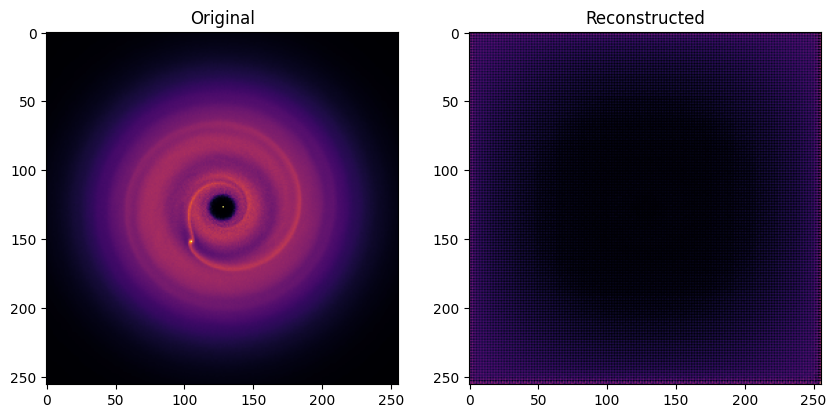

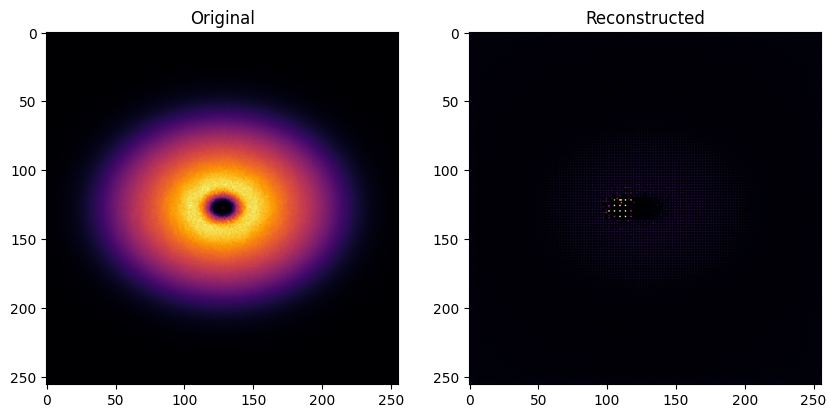

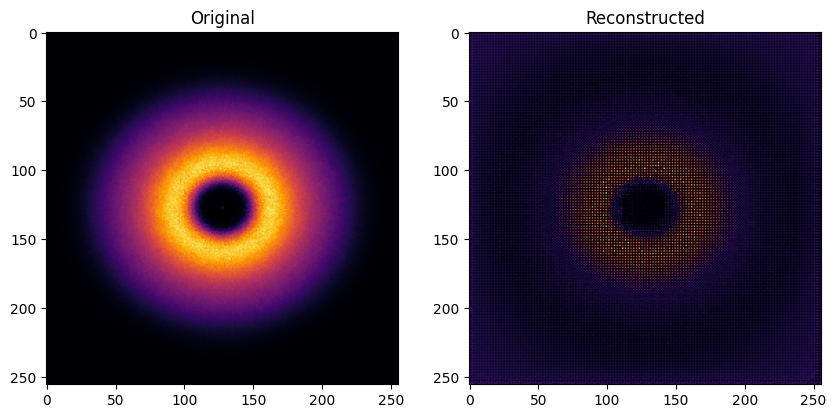

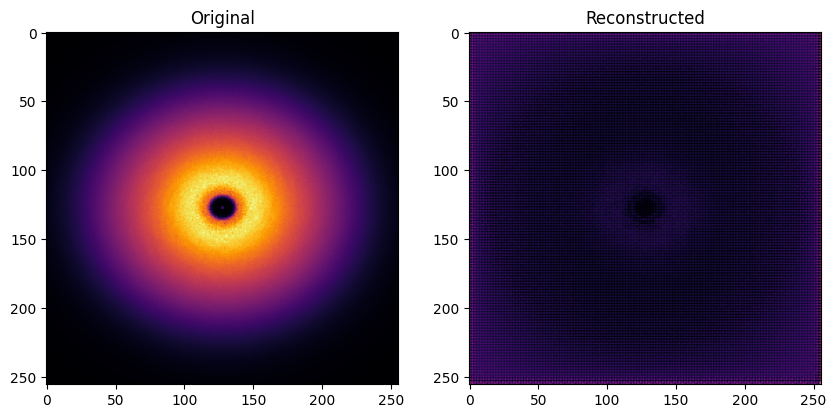

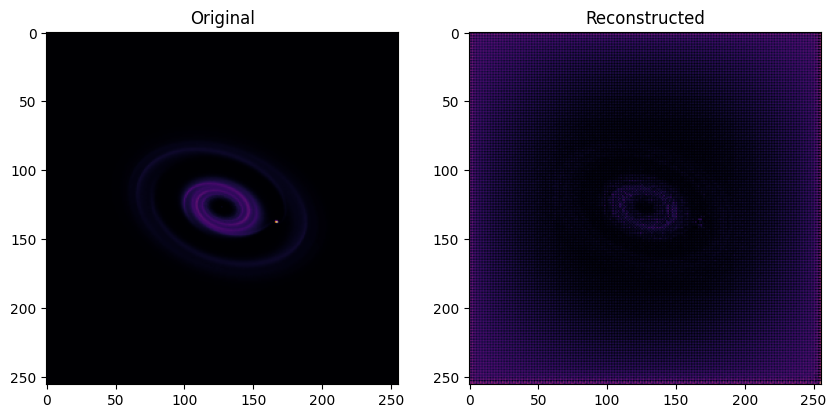

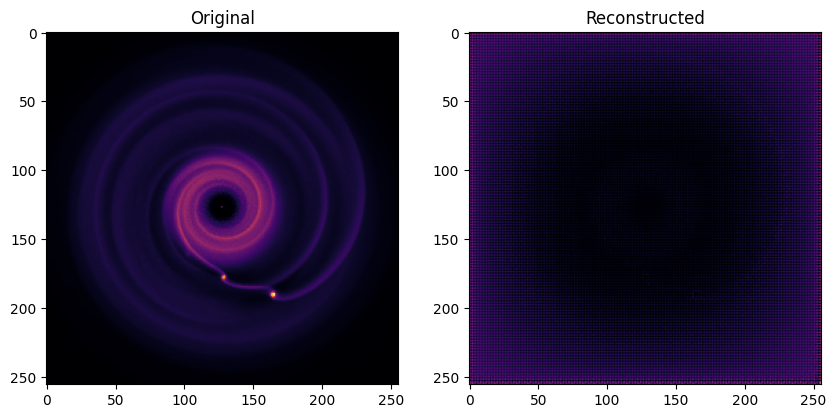

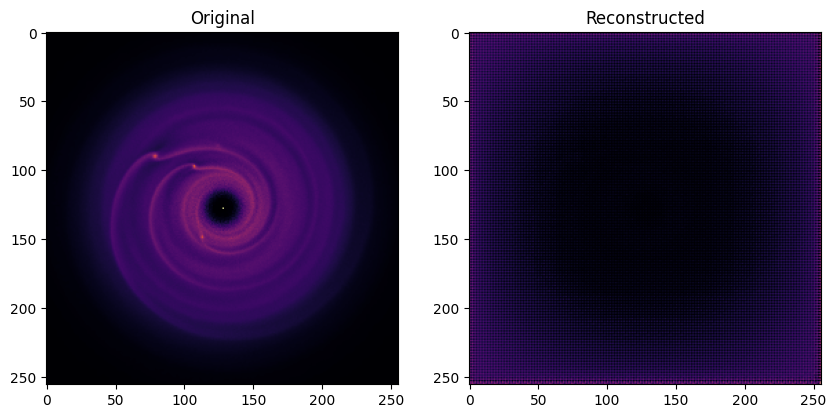

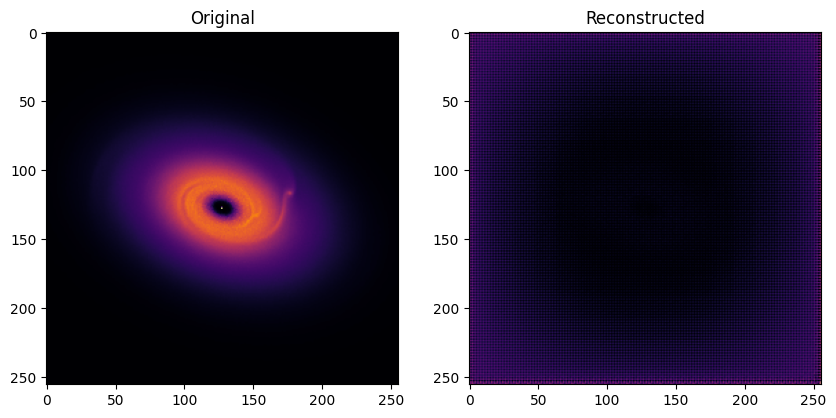

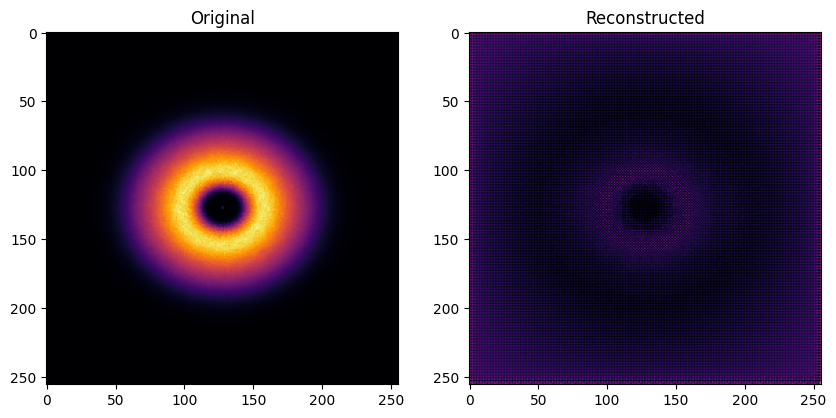

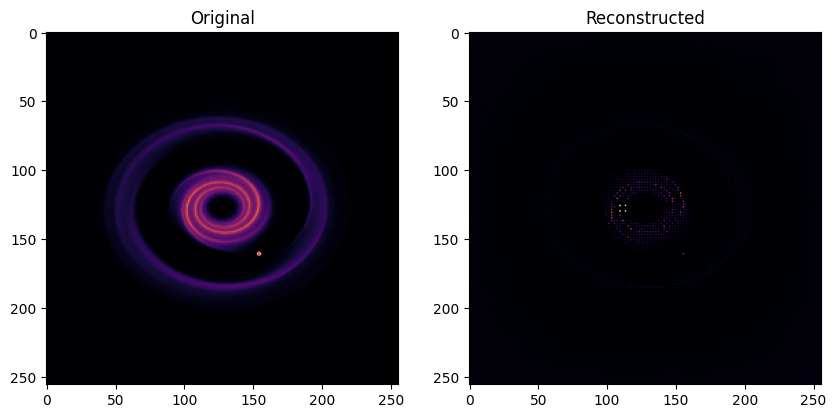

In [75]:
sample_tensor, _, original_min, original_max = next(iter(dataloader))


num_images = min(10, sample_tensor.size(0))

for i in range(num_images):
    original = sample_tensor[i]
    orig_min = original_min[i]
    orig_max = original_max[i]


    reconstructed, _ = infer(model, original)


    original_denorm = original * (orig_max - orig_min + 1e-8) + orig_min
    reconstructed_denorm = reconstructed * (orig_max - orig_min + 1e-8) + orig_min


    show_image_pair(original_denorm, reconstructed_denorm)
